# Toy example for Feature Subset selection with Estimation of Distribution Algorithms

In this notebooks we show a toy example for feature selection using the binary implementation of EDA in EDAspy. For this, we try to select the optimal subset of variables for a forecasting model. The metric that we use for evaluation is the Mean Absolute Error (MAE) of the subset in the forecasting model.

In [1]:
# loading essential libraries first
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# EDAspy libraries
from EDAspy.optimization import UMDAd

We will use a small dataset to show an example of usage. We usually use a Feature Subset selector when a great amount of variables is available to use

In [2]:
# import some data
mdata = sm.datasets.macrodata.load_pandas().data
df = mdata.iloc[:, 2:]
df.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [4]:
variables = list(df.columns)
variable_y = 'pop'  # pop is the variable we want to forecast
variables = list(set(variables) - {variable_y})  # array of variables to select among transformations
variables

['realinv',
 'realgdp',
 'm1',
 'unemp',
 'realdpi',
 'realint',
 'realcons',
 'tbilrate',
 'realgovt',
 'cpi',
 'infl']

We define a cost function which receives a dictionary with variables names as keys of the dictionary and values 1/0 if they are used or not respectively.

The functions returns the Mean Absolute Error found with the combination of variables selected.

In [15]:
def cost_function(variables_list, nobs=20, maxlags=10, forecastings=10):
    """
    variables_list: array of size the number of variables, where a 1 is to choose the variable, and 0 to reject it.
    nobs: how many observations for validation
    maxlags: previous lags used to predict
    forecasting: number of observations to predict
    
    return: MAE of the prediction with the real validation data
    """

    variables_chosen = []
    for i, j in zip(variables, variables_list):
        if j == 1:
            variables_chosen.append(i)

    data = df[variables_chosen + [variable_y]]

    df_train, df_test = data[0:-nobs], data[-nobs:]

    model = VAR(df_train)
    results = model.fit(maxlags=maxlags, ic='aic')

    lag_order = results.k_ar
    array = results.forecast(df_train.values[-lag_order:], forecastings)

    variables_ = list(data.columns)
    position = variables_.index(variable_y)

    validation = [array[i][position] for i in range(len(array))]
    mae = mean_absolute_error(validation, df_test['pop'][-forecastings:])
    
    return mae

We calculate the MAE found using all the variables.

This is an easy example so the difference between the MAE found using all the variables and the MAE found after optimizing the model, will be very small. But this is appreciated with more difference when large datasets are used

In [16]:
# build the dictionary with all 1s
selection = [1]*len(variables)

mae_pre_eda = cost_function(selection)
print('MAE without using EDA:', mae_pre_eda)

MAE without using EDA: 7.06163456694552


We initialize the EDA weith the following parameters, and run the optimizer over the cost function defined above. The vector of statistics is initialized to None so the EDA implementation will initialize it. If you desire to initialize it in a way to favour some of the variables you can create a numpy array with all the variables the same probability to be chosen or not (0.5), and the one you want to favour to nearly 1. This will make the EDA to choose the variable nearly always.

In [17]:
eda = UMDAd(size_gen=30, max_iter=100, dead_iter=10, n_variables=len(variables), alpha=0.5, vector=None,
            lower_bound=0.2, upper_bound=0.9, elite_factor=0.2, disp=True)

eda_result = eda.minimize(cost_function=cost_function, output_runtime=True)

IT:  0 	Best cost:  6.613299985219163
IT:  1 	Best cost:  6.458211125755793
IT:  2 	Best cost:  6.356182733658363
IT:  3 	Best cost:  6.356182733658363
IT:  4 	Best cost:  6.356182733658363
IT:  5 	Best cost:  6.356182733658363
IT:  6 	Best cost:  6.356182733658363
IT:  7 	Best cost:  6.356182733658363
IT:  8 	Best cost:  6.356182733658363
IT:  9 	Best cost:  6.356182733658363
IT:  10 	Best cost:  6.356182733658363
IT:  11 	Best cost:  6.356182733658363
	NFVALS = 390 F = 6.356182733658363
	X = [0 1 1 1 1 1 1 1 1 1 1]


Note that the algorithm is minimzing correctly, but doe to the fact that it is a toy example, there is not a high variance from the beginning to the end.

In [28]:
print('Best cost found:', eda_result.best_cost)
print('Variables chosen')
variables_chosen = []
for i, j in zip(variables, eda_result.best_ind):
        if j == 1:
            variables_chosen.append(i)
print(variables_chosen)

Best cost found: 6.356182733658363
Variables chosen
['realgdp', 'm1', 'unemp', 'realdpi', 'realint', 'realcons', 'tbilrate', 'realgovt', 'cpi', 'infl']


# Some plots

We plot the best cost in each iteration to show how the MAE of the feature selection is reduced compared to using all the variables.

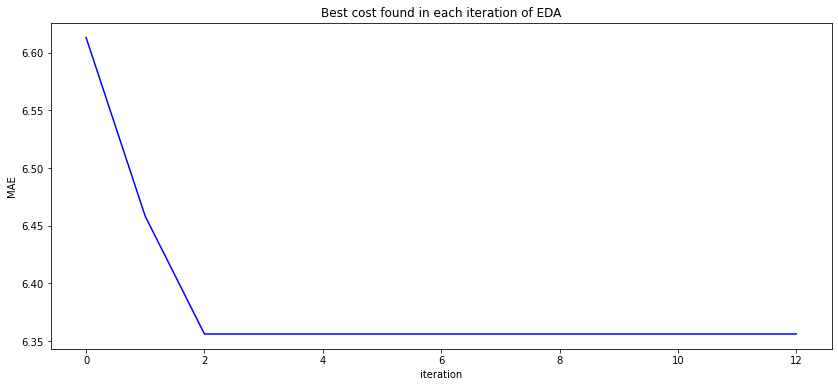

In [26]:
plt.figure(figsize = (14,6))

plt.title('Best cost found in each iteration of EDA')
plt.plot(list(range(len(eda_result.history))), eda_result.history, color='b')
plt.xlabel('iteration')
plt.ylabel('MAE')
plt.show()